In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import pydot
from IPython.display import Image

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [3]:
featuresA = ["has_name", "has_image", "has_location",
             "normal_name",
             "has_biography", "tweet_count",
             "followers_count", "friends_count",
             "ratio_followers_friends", "ratio_friends_followers",
             "ratio_followers_friends_pow", "ratio_friends_followers_pow",
             "has_url", "bot_in_biography",
             "is_listed", "listed_count"]

In [4]:
cresci2015files = glob("datas/cresci-2015/*/users.csv")
tmp = []
for f in cresci2015files:
    df = pd.read_csv(f, index_col=None, header=0)
    tmp.append(df)
cresci2015 = pd.concat(tmp)
cresci2015 = cresci2015.set_index("id")

In [5]:
cresci2015["tweet_count"] = cresci2015.statuses_count
cresci2015 = cresci2015.fillna(0)
replace_from = ["name", "location", "default_profile_image", "description", "url", "listed_count"]
replace_to = ["has_name", "has_location", "has_image", "has_biography", "has_url", "is_listed"]
cresci2015[replace_to] = cresci2015[replace_from].astype(bool)
cresci2015["normal_name"] = cresci2015.name.str.contains(r"^[a-zA-Z0-9\s\.]+$")
cresci2015["ratio_followers_friends"] = cresci2015.followers_count / cresci2015.friends_count
cresci2015["ratio_friends_followers"] = cresci2015.friends_count / cresci2015.followers_count
cresci2015["ratio_followers_friends_pow"] = cresci2015.followers_count / cresci2015.friends_count**2
cresci2015["ratio_friends_followers_pow"] = cresci2015.friends_count / cresci2015.followers_count**2
cresci2015["bot_in_biography"] = cresci2015.description.str.contains("\Wbot\W").fillna(False)

In [6]:
cresci2015

,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,created_at,url,lang,...,has_image,has_biography,has_url,is_listed,normal_name,ratio_followers_friends,ratio_friends_followers,ratio_followers_friends_pow,ratio_friends_followers_pow,bot_in_biography
id,,,,,,,,,,,,,,,,,,,,,
1120176186,Madonna Carson,MadonnaCarson,22,11,257,0,0,Fri Jan 25 20:18:39 +0000 2013,0,en,...,False,True,False,False,True,0.042802,23.363636,0.000167,2.123967,False
1124249136,Ardelle Mckee,ArdelleMckee,20,11,226,0,0,Sun Jan 27 07:18:34 +0000 2013,0,en,...,False,False,False,False,True,0.048673,20.545455,0.000215,1.867769,False
1124264132,Isadora Wilson,IsadoraWilson,19,13,281,0,0,Sun Jan 27 07:19:28 +0000 2013,0,en,...,False,True,False,False,True,0.046263,21.615385,0.000165,1.662722,False
1124293891,Genesis Merrill,GenesisMerrill,21,19,237,0,0,Sun Jan 27 07:33:40 +0000 2013,0,en,...,False,True,False,False,True,0.080169,12.473684,0.000338,0.656510,False
1124295318,Kent Caldwell,KentCaldwell3,22,20,262,0,0,Sun Jan 27 07:43:52 +0000 2013,0,en,...,False,False,False,False,True,0.076336,13.100000,0.000291,0.655000,False
1124301420,Drucilla Sellers,DrucillaSeller1,19,14,269,1,0,Sun Jan 27 07:47:15 +0000 2013,0,en,...,False,True,False,False,True,0.052045,19.214286,0.000193,1.372449,False
1124314592,Helaine Taylor,HelaineTaylor,22,13,242,0,0,Sun Jan 27 07:46:58 +0000 2013,0,en,...,False,True,False,False,True,0.053719,18.615385,0.000222,1.431953,False
1124348202,Senaida Hayes,SenaidaHayes,19,8,235,0,0,Sun Jan 27 08:11:56 +0000 2013,0,en,...,False,True,False,False,True,0.034043,29.375000,0.000145,3.671875,False
1124360551,Mayra Glass,MayraGlass11,23,13,265,0,0,Sun Jan 27 08:09:15 +0000 2013,0,en,...,False,True,False,False,True,0.049057,20.384615,0.000185,1.568047,False


In [7]:
X = cresci2015[featuresA].astype("float32").replace([np.inf, -np.inf], np.nan).fillna(0)
Y = (cresci2015.dataset == "TFP") | (cresci2015.dataset == "E13")
Y = Y.astype("int")

In [8]:
X

,has_name,has_image,has_location,normal_name,has_biography,tweet_count,followers_count,friends_count,ratio_followers_friends,ratio_friends_followers,ratio_followers_friends_pow,ratio_friends_followers_pow,has_url,bot_in_biography,is_listed,listed_count
id,,,,,,,,,,,,,,,,
1120176186,1.0,0.0,1.0,1.0,1.0,22.0,11.0,257.0,0.042802,23.363636,0.000167,2.123967,0.0,0.0,0.0,0.0
1124249136,1.0,0.0,1.0,1.0,0.0,20.0,11.0,226.0,0.048673,20.545454,0.000215,1.867769,0.0,0.0,0.0,0.0
1124264132,1.0,0.0,1.0,1.0,1.0,19.0,13.0,281.0,0.046263,21.615385,0.000165,1.662722,0.0,0.0,0.0,0.0
1124293891,1.0,0.0,1.0,1.0,1.0,21.0,19.0,237.0,0.080169,12.473684,0.000338,0.656510,0.0,0.0,0.0,0.0
1124295318,1.0,0.0,1.0,1.0,0.0,22.0,20.0,262.0,0.076336,13.100000,0.000291,0.655000,0.0,0.0,0.0,0.0
1124301420,1.0,0.0,1.0,1.0,1.0,19.0,14.0,269.0,0.052045,19.214285,0.000193,1.372449,0.0,0.0,0.0,0.0
1124314592,1.0,0.0,1.0,1.0,1.0,22.0,13.0,242.0,0.053719,18.615385,0.000222,1.431953,0.0,0.0,0.0,0.0
1124348202,1.0,0.0,1.0,1.0,1.0,19.0,8.0,235.0,0.034043,29.375000,0.000145,3.671875,0.0,0.0,0.0,0.0
1124360551,1.0,0.0,1.0,1.0,1.0,23.0,13.0,265.0,0.049057,20.384615,0.000185,1.568047,0.0,0.0,0.0,0.0


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

In [10]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.98057142857142854

In [11]:
for i,name in enumerate(featuresA):
    print("{} : {:.3}".format(name, clf.feature_importances_[i]))

has_name : 0.0
has_image : 0.00343
has_location : 0.00212
normal_name : 0.000483
has_biography : 0.00532
tweet_count : 0.0925
followers_count : 0.0153
friends_count : 0.02
ratio_followers_friends : 0.22
ratio_friends_followers : 0.201
ratio_followers_friends_pow : 0.212
ratio_friends_followers_pow : 0.121
has_url : 0.00134
bot_in_biography : 0.0
is_listed : 0.0694
listed_count : 0.0357


In [12]:
clf = DecisionTreeClassifier()
clf.fit(X_train, Y_train)
clf.score(X_test, Y_test)

0.97371428571428575

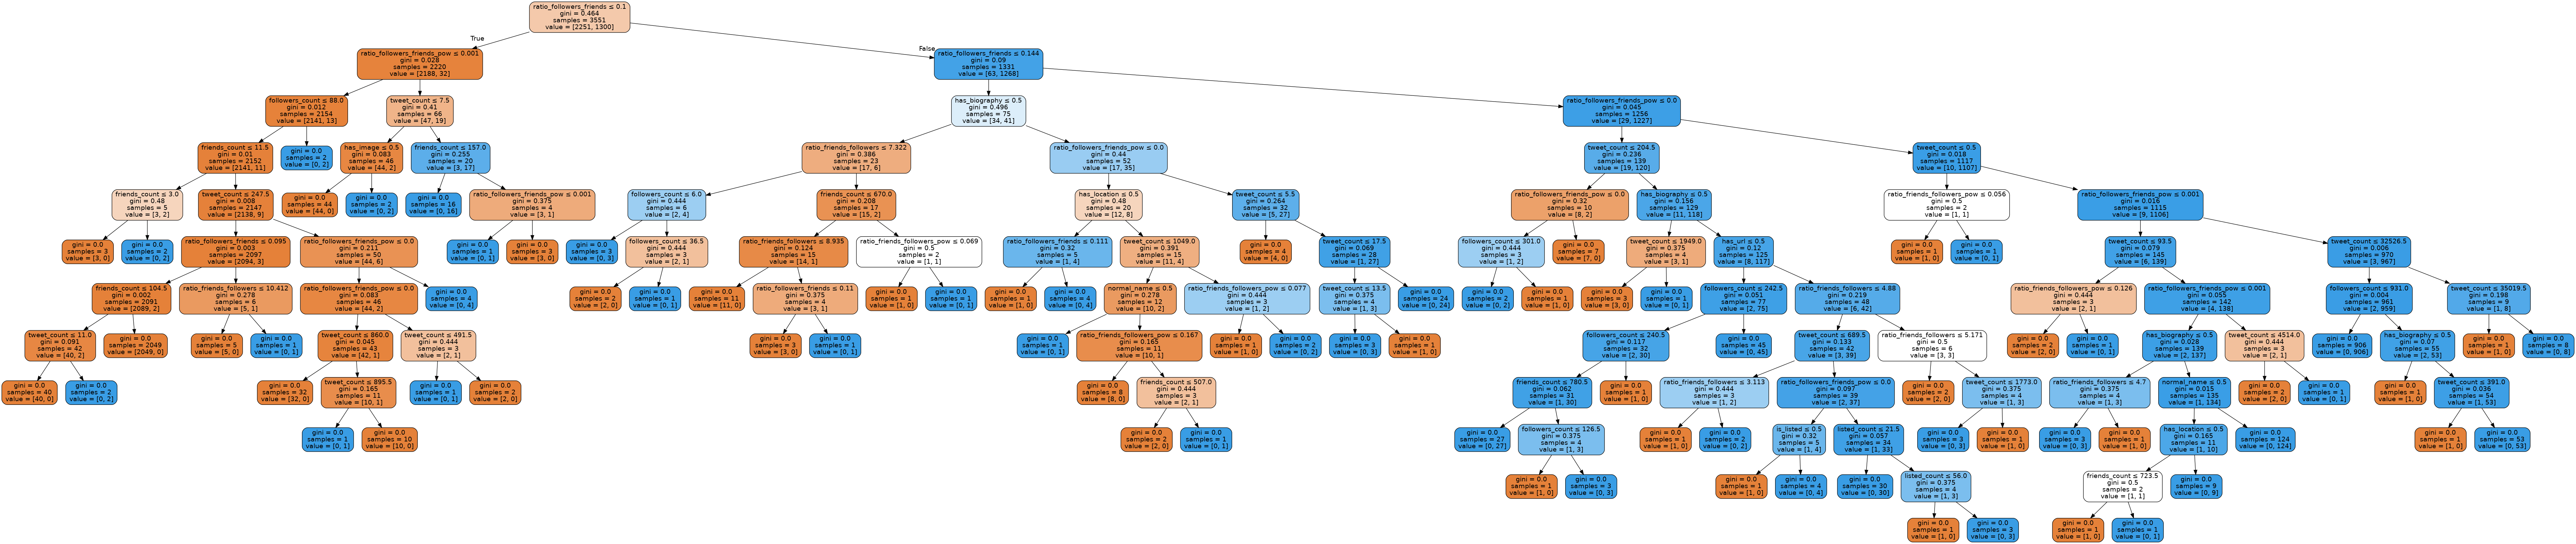

In [13]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=featuresA,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data)
Image(graph[0].create_png())

In [14]:
cresci2015.name.str.contains(r"^[a-zA-Z0-9\s\.]+$").all()

False